### Objective: retrieve the words corresponding to a state change as embeddings to see if they share some common features

In [6]:
# --- Step 1: Load and print color transitions ---
import pickle
import numpy as np
import os
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Add src directory to Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import MODEL_NAME

# Load the log
with open("data/clustering/color_transitions_log.pkl", "rb") as f:
    color_log = pickle.load(f)

print(f"Loaded {len(color_log)} samples\n")

# --- Print a few sample entries ---
NUM_TO_PRINT = 5

for i, entry in enumerate(color_log[:NUM_TO_PRINT]):
    print(f"Sample {i + 1}")
    print("Tokens:", ' '.join(entry["tokens"]))
    print("Transitions:", entry["transitions"])
    print("States:", entry["states"])
    print("-" * 50)

Loaded 20 samples

Sample 1
Tokens: [CLS] i love sci - fi and am willing to put up with a lot . sci - fi movies / tv are usually under ##fu ##nded , under - appreciated and misunderstood . i tried to like this , i really did , but it is to good tv sci - fi as babylon 5 is to star trek ( the original ) . silly pro ##st ##hetic ##s , cheap cardboard sets , stil ##ted dialogues , c ##g that doesn ' t match the background , and painfully one - dimensional characters cannot be overcome with a
Transitions: [(0, 5), (5, 35), (35, 44), (44, 65), (65, 85), (85, 100)]
States: [np.int64(2), np.int64(1), np.int64(2), np.int64(1), np.int64(2), np.int64(0)]
--------------------------------------------------
Sample 2
Tokens: [CLS] worth the entertainment value of a rental , especially if you like action movies . this one features the usual car chases , fights with the great van dam ##me kick style , shooting battles with the 40 shell load shotgun , and even terrorist style bombs . all of this is ente

In [7]:
# At each transition index, get the token at that index
transition_tokens = []

for entry in color_log:
    tokens = entry["tokens"]
    transitions = entry["transitions"]  # e.g. [(0,3), (3,6), (6,8)]

    # transitions is a list of (start, end) ranges
    # we care about the *start index* of each segment after the first
    for start_idx, _ in transitions[1:]:  # skip the first
        if start_idx < len(tokens):
            transition_tokens.append(tokens[start_idx])


In [8]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pretrained model (any good BERT variant)
model_name = MODEL_NAME
tok = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)
bert.eval()

# Deduplicate words and get their embeddings
unique_tokens = list(set(transition_tokens))
print(f"Unique transition tokens: {len(unique_tokens)}")

def embed_token(token):
    with torch.no_grad():
        inputs = tok(token, return_tensors="pt")
        outputs = bert(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        return cls_embedding.squeeze().numpy()

embedding_matrix = np.array([embed_token(tok) for tok in unique_tokens])


Unique transition tokens: 32


In [9]:
import plotly.express as pxa
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.io as pio

# Try these one at a time depending on your setup
# Best for Jupyter Lab / VSCode
pio.renderers.default = "iframe_connected"

# K-Means clustering

In [11]:
! pip install --upgrade kaleido

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.7 MB/s eta 0:00:000m eta 0:00:010:01:01


Explained variance by Component 1: 0.4406 (44.06%)
Explained variance by Component 2: 0.1898 (18.98%)
Total explained variance by plotted components: 0.6304 (63.04%)


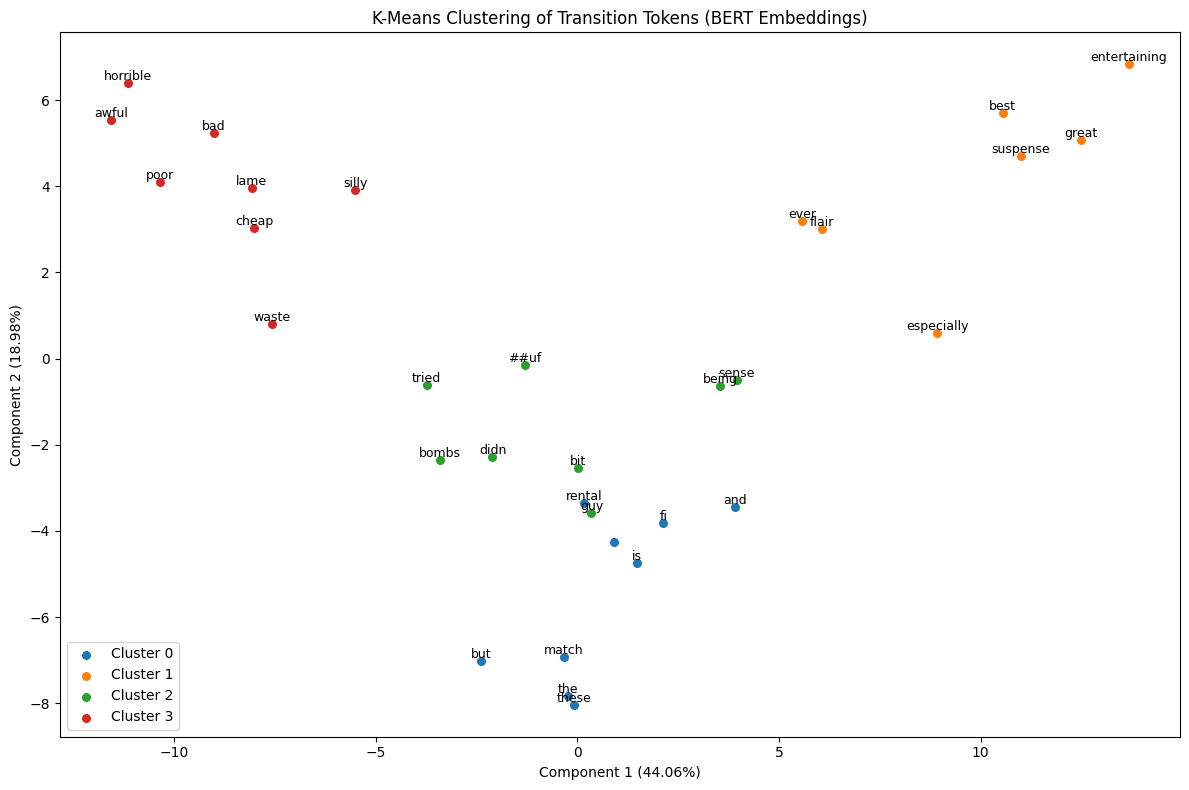

PNG image saved as 'KMEANS.png'.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- Clustering ---
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embedding_matrix)

# --- Dimensionality reduction ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embedding_matrix)

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_sum = explained_variance_ratio.sum()

print(f"Explained variance by Component 1: {explained_variance_ratio[0]:.4f} ({explained_variance_ratio[0]*100:.2f}%)")
print(f"Explained variance by Component 2: {explained_variance_ratio[1]:.4f} ({explained_variance_ratio[1]*100:.2f}%)")
print(f"Total explained variance by plotted components: {explained_variance_sum:.4f} ({explained_variance_sum*100:.2f}%)")

# --- Prepare DataFrame ---
df = pd.DataFrame({
    "Token": unique_tokens,
    "Cluster": labels,
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
})

# --- Plotting with Matplotlib ---
plt.figure(figsize=(12, 8))

# Plot each cluster with a different color
for cluster in range(n_clusters):
    cluster_df = df[df['Cluster'] == cluster]
    plt.scatter(cluster_df['PCA1'], cluster_df['PCA2'], label=f'Cluster {cluster}', s=30)

    # Add labels
    for _, row in cluster_df.iterrows():
        plt.text(row['PCA1'], row['PCA2'], row['Token'], fontsize=9, ha='center', va='bottom')

plt.xlabel(f"Component 1 ({explained_variance_ratio[0]*100:.2f}%)")
plt.ylabel(f"Component 2 ({explained_variance_ratio[1]*100:.2f}%)")
plt.title("K-Means Clustering of Transition Tokens (BERT Embeddings)")
plt.legend()
plt.tight_layout()

# Save the figure as PNG
plt.savefig("KMEANS.png", dpi=300)
plt.show()
plt.close()

print("PNG image saved as 'KMEANS.png'.")
